In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, matthews_corrcoef, roc_curve, auc, precision_recall_curve, make_scorer
from scipy.stats import gmean
from imblearn.metrics import geometric_mean_score
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

## Loading, Scaling and Spltting the data

Since the entire dataset was PCA encoded and "Time" and "Amount" columns were left as it is, after loading the dataset, we scale only the "Time" and "Amount" columns in our dataset using StandardScaler() to maintain consistency.

In [2]:
# Loading the data
df = pd.read_csv(r"C:\Users\Sana\OneDrive\Desktop\creditcard.csv")

# Scaling "time" and "amount" columns:
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

In [3]:
# Splitting the data into training, validation and testing sets in 60-20-20 ratio repectively
X = df.drop('Class',axis = 1)
y = df['Class']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify = y, test_size=0.4,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [4]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((170884, 30), (56961, 30), (56962, 30), (170884,), (56961,), (56962,))

## Local Outlier Factor Model

We first create an LOF model as our base model. We extract outlier scores from it and then append them to our original input datasets.

In [5]:
# Local Outlier Factor model
lof = LocalOutlierFactor(contamination='auto', novelty=True)

In [6]:
lof.fit(X_train)

LocalOutlierFactor(novelty=True)

In [7]:
y_train.value_counts()

0    170589
1       295
Name: Class, dtype: int64

In [8]:
# Getting the outlier scores
train_scores_lof = -lof.decision_function(X_train)
val_scores_lof = -lof.decision_function(X_val)
test_scores_lof = -lof.decision_function(X_test)

C:\Users\Sana\anaconda3\envs\rstudio\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\Sana\anaconda3\envs\rstudio\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\Sana\anaconda3\envs\rstudio\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  "X does not have valid feature names, but"


In [9]:
# Combining input features with outlier scores
train_data_with_scores_lof = np.hstack((X_train, train_scores_lof.reshape(-1, 1)))
val_data_with_scores_lof = np.hstack((X_val, val_scores_lof.reshape(-1, 1)))
test_data_with_scores_lof = np.hstack((X_test, test_scores_lof.reshape(-1, 1)))

In [10]:
train_df = pd.DataFrame(train_data_with_scores_lof, columns=list(X.columns) + ['lof_score'])
val_df = pd.DataFrame(val_data_with_scores_lof, columns=list(X.columns) + ['lof_score'])
test_df = pd.DataFrame(test_data_with_scores_lof, columns=list(X.columns) + ['lof_score'])

## Evalution Metrics

We make use of TensorFlow with Keras to build our MLP model. We need to define a custom function for Geometric Mean score, F1 score, and Matthews Correlation Coefficient since they are not directly available as built-in metrics in TensorFlow.

In [11]:
# F1 Score
def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Matthews correlation coefficient (MCC)
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

# G-Mean: Geometric mean of specificity and sensitivity
def g_mean(y_true, y_pred):
    sensitivity = tf.keras.metrics.Recall()(y_true, y_pred)
    specificity = tf.keras.metrics.Recall()(1-y_true, 1-y_pred)
    return K.sqrt(sensitivity * specificity)

# List of metrics
metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
           f1_score, tf.keras.metrics.AUC(name='roc_auc'), tf.keras.metrics.AUC(name='auprc', curve='PR'), 
           matthews_correlation, g_mean]

metrics

['accuracy',
 <function __main__.f1_score(y_true, y_pred)>,
 <function __main__.matthews_correlation(y_true, y_pred)>,
 <function __main__.g_mean(y_true, y_pred)>]

## MLP Model

We define an MLP model having a sequential architecture containing an input layer with dimension "train_df.shape[1]" and 64 neurons, a hidden layer with 64 neurons and an output layer with 1 neuron. This model also consists of two Dropout layers which helps in preventing overfitting. 

"train_df.shape[1]" is nothing but the number of columns in train_df.

We utilise activation function 'relu' for our input layer and hidden layers and 'sigmoid' for output layer. Activation function introduces non-linearity to the model which helps the model capture more complex patterns. 

We use 'adam' as our optimizer and 'binary_crossentropy' as the loss function during the training process as it is apt for binary classification problems. All the metrics specified in 'metrics' list are used to check the model's performance. 

In [12]:
def mlp_model(hidden_units_1=64, hidden_units_2=64, dropout_rate=0.5):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_units_1, activation='relu', input_dim=train_df.shape[1]),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(hidden_units_2, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    return model

We 'wrap' the model in KerasClassifier in order to use scikit learn for hyperparameter tuning and stratified k-fold cross validation later. 

In [13]:
# Wrapping the model with KerasClassifier
model = KerasClassifier(build_fn=mlp_model, epochs=10, batch_size=256, verbose=0)

We perform hyperparameter tuning using BayesSearchCV which uses Bayesian optimization to search for the best parameters from the search space provided. 

To incorporate cost sensitive learning, we also define weights so that minority class is given more importance. 

In [14]:
search_space = {
    'hidden_units_1': Integer(32, 256),
    'hidden_units_2': Integer(32, 256),
    'dropout_rate': Real(0.2, 0.7)
}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
# initialising BayesSearchCV
bayes_search = BayesSearchCV(model, search_spaces=search_space, n_iter=15, scoring='precision', cv=stratified_kfold, n_jobs=1, verbose=1, random_state=42)

In [16]:
# Calculate class weights
weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Create sample weights for training data using NumPy indexing
sample_weights = np.array([class_weights[label] for label in y_train])

In [17]:
sample_weights

array([0.50086465, 0.50086465, 0.50086465, ..., 0.50086465, 0.50086465,
       0.50086465])

In [18]:
bayes_search.fit(train_df, y_train, sample_weight=sample_weights)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\Sana\anaconda3\envs\rstudio\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002946A0EEB70>,
              n_iter=15, random_state=42, scoring='precision',
              search_spaces={'dropout_rate': Real(low=0.2, high=0.7, prior='uniform', transform='normalize'),
                             'hidden_units_1': Integer(low=32, high=256, prior='uniform', transform='normalize'),
                             'hidden_units_2': Integer(low=32, high=256, prior='uniform', transform='normalize')},
              verbose=1)

In [19]:
# Getting the best parameters
best_params = bayes_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  OrderedDict([('dropout_rate', 0.7), ('hidden_units_1', 82), ('hidden_units_2', 256)])


In [20]:
# Fitting the best parameters into our model
best_model = mlp_model(
    hidden_units_1=best_params['hidden_units_1'], 
    hidden_units_2=best_params['hidden_units_2'], 
    dropout_rate=best_params['dropout_rate']
)

In [21]:
# Compiling the model
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [22]:
# Training the best model on training set 
history = best_model.fit(train_df, y_train, sample_weight=sample_weights, epochs=10, batch_size=256, validation_data=(val_df, y_val), verbose=1)

Train on 170884 samples, validate on 56961 samples
Epoch 1/10
170884/170884 [==============================] - 12s 72us/sample - loss: 1.0797 - accuracy: 0.9866 - precision: 0.0796 - recall: 0.6407 - f1_score: 0.0907 - roc_auc: 0.8512 - auprc: 0.4387 - matthews_correlation: 0.1420 - g_mean: 0.6021 - val_loss: 0.0220 - val_accuracy: 0.9986 - val_precision: 0.6241 - val_recall: 0.7857 - val_f1_score: 0.1628 - val_roc_auc: 0.9397 - val_auprc: 0.6660 - val_matthews_correlation: 0.2971 - val_g_mean: 0.8046
Epoch 2/10
170884/170884 [==============================] - 10s 61us/sample - loss: 0.3188 - accuracy: 0.9625 - precision: 0.0390 - recall: 0.8780 - f1_score: 0.1339 - roc_auc: 0.9515 - auprc: 0.5286 - matthews_correlation: 0.1067 - g_mean: 0.8446 - val_loss: 0.0349 - val_accuracy: 0.9960 - val_precision: 0.3079 - val_recall: 0.8304 - val_f1_score: 0.1157 - val_roc_auc: 0.9482 - val_auprc: 0.6707 - val_matthews_correlation: 0.2626 - val_g_mean: 0.8675
Epoch 3/10
170884/170884 [===========

## Validation Set Results

In [23]:
# Evaluating the model on validation set
val_loss = best_model.evaluate(val_df, y_val)
print(val_loss)

56961/56961 [==============================] - 2s 42us/sample - loss: 0.0339 - accuracy: 0.9970 - precision: 0.3837 - recall: 0.8393 - f1_score: 0.1078 - roc_auc: 0.9844 - auprc: 0.7022 - matthews_correlation: 0.0497 - g_mean: 0.9226
[0.03387801930797188, 0.99703306, 0.38367346, 0.83928573, 0.10779818, 0.9843956, 0.7021821, 0.049681216, 0.9225713]


In [24]:
y_pred_val = (best_model.predict(val_df) > 0.8).astype(int)
y_pred_val = y_pred_val.flatten()

# Calculating evaluation metrics on the validation set
val_accuracy = accuracy_score(y_val, y_pred_val)
val_precision = precision_score(y_val, y_pred_val)
val_recall = recall_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)
val_roc_auc = roc_auc_score(y_val, y_pred_val)
val_pr_auc = average_precision_score(y_val, y_pred_val)
val_mcc = matthews_corrcoef(y_val, y_pred_val)
val_g_mean = geometric_mean_score(y_val, y_pred_val)
val_cm = confusion_matrix(y_val, y_pred_val)

In [25]:
val_results = {
    'Accuracy': val_accuracy,
    'Precision': val_precision,
    'Recall': val_recall,
    'F1 Score': val_f1,
    'ROC AUC Score': val_roc_auc,
    'PR AUC': val_pr_auc,
    'Matthews Correlation Coefficient': val_mcc,
    'G-Mean': val_g_mean,
    'Confusion Matrix': val_cm
}

val_results

{'Accuracy': 0.9991573181650603,
 'Precision': 0.7962962962962963,
 'Recall': 0.7678571428571429,
 'F1 Score': <tf.Tensor: id=5683473, shape=(), dtype=float32, numpy=0.7818181>,
 'ROC AUC Score': 0.8837350763802856,
 'PR AUC': 0.6118982516023913,
 'Matthews Correlation Coefficient': 0.7815258542744341,
 'G-Mean': 0.8761050106849495,
 'Confusion Matrix': array([[56827,    22],
        [   26,    86]], dtype=int64)}

## Test Set Results

In [26]:
# Evaluating the best model on test set
test_loss = best_model.evaluate(test_df, y_test)
test_loss

56962/56962 [==============================] - 2s 40us/sample - loss: 0.0326 - accuracy: 0.9973 - precision: 0.3380 - recall: 0.8471 - f1_score: 0.1097 - roc_auc: 0.9765 - auprc: 0.7145 - matthews_correlation: 0.0388 - g_mean: 0.9225


[0.03258484374910451,
 0.99729645,
 0.33802816,
 0.84705883,
 0.10969321,
 0.9765005,
 0.7145441,
 0.038839787,
 0.9225103]

In [27]:
test_results_ = best_model.evaluate(test_df, y_test)
print(test_results_)

56962/56962 [==============================] - 2s 40us/sample - loss: 0.0326 - accuracy: 0.9973 - precision: 0.3380 - recall: 0.8471 - f1_score: 0.1113 - roc_auc: 0.9765 - auprc: 0.7145 - matthews_correlation: 0.0388 - g_mean: 0.9225
[0.03258484374910451, 0.99729645, 0.33802816, 0.84705883, 0.11134233, 0.9765005, 0.7145441, 0.038839787, 0.922495]


In [28]:
y_pred_test = (best_model.predict(test_df) > 0.8).astype(int)
y_pred_test = y_pred_test.flatten()

# Calculating evaluation metrics on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_pred_test)
test_pr_auc = average_precision_score(y_test, y_pred_test)
test_mcc = matthews_corrcoef(y_test, y_pred_test)
test_g_mean = geometric_mean_score(y_test, y_pred_test)
test_cm = confusion_matrix(y_test, y_pred_test)

In [29]:
test_results = {
    'Accuracy': test_accuracy,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1 Score': test_f1,
    'ROC AUC Score': test_roc_auc,
    'PR AUC': test_pr_auc,
    'Matthews Correlation Coefficient': test_mcc,
    'G-Mean': test_g_mean,
    'Confusion Matrix': test_cm
}

test_results

{'Accuracy': 0.9993153330290369,
 'Precision': 0.7613636363636364,
 'Recall': 0.788235294117647,
 'F1 Score': <tf.Tensor: id=5726414, shape=(), dtype=float32, numpy=0.7745665>,
 'ROC AUC Score': 0.8939330381659494,
 'PR AUC': 0.6004496899800167,
 'Matthews Correlation Coefficient': 0.7743405128449987,
 'G-Mean': 0.8876622463683495,
 'Confusion Matrix': array([[56856,    21],
        [   18,    67]], dtype=int64)}

In [30]:
y_test.value_counts()

0    56877
1       85
Name: Class, dtype: int64

## ROC - AUC

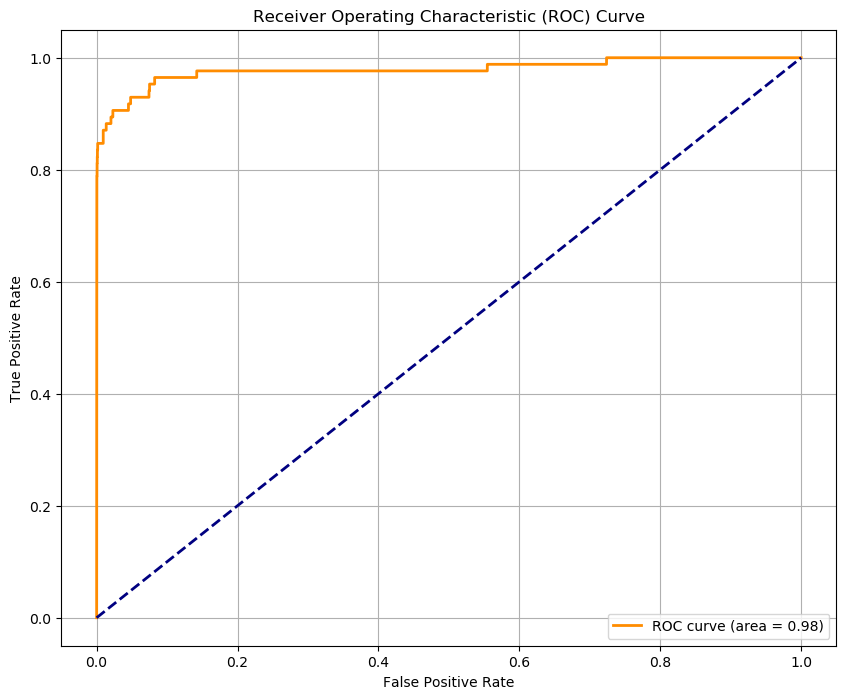

In [31]:
y_pred_prob_test = best_model.predict(test_df).flatten()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## PR - AUC

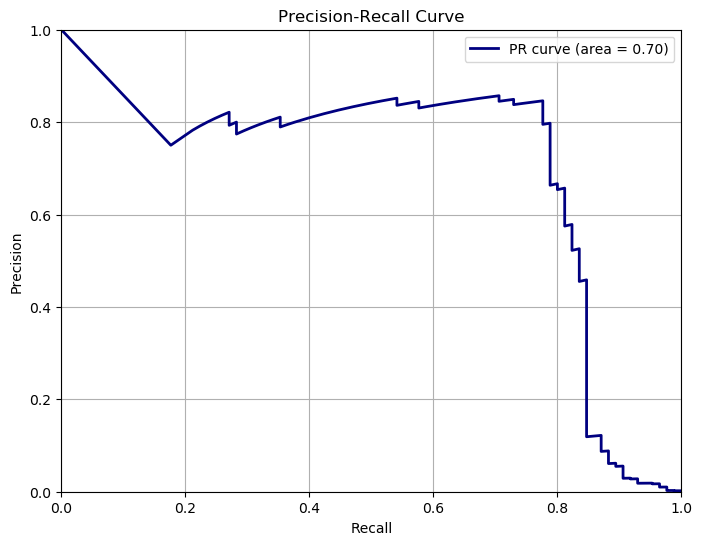

In [32]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_test)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='navy', lw=2, label='PR curve (area = %0.2f)' % pr_auc)

# Set the axis limits to start from 0
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

## Confusion Matrix

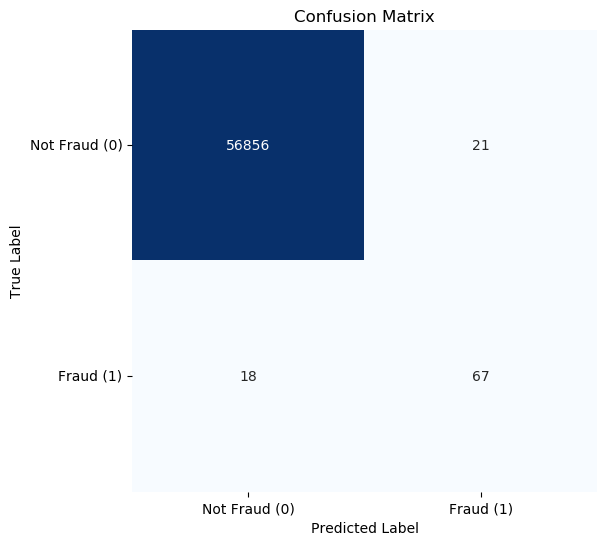

In [33]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Not Fraud (0)', 'Fraud (1)'], yticklabels=['Not Fraud (0)', 'Fraud (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.yticks(rotation=360)  
plt.show()